##### Initial setup

In [ ]:
#@markdown <b>Run me to import underscore module</b><br/>   {display-mode: "form"}
#@markdown <small>Method signatures:</small><br/> 
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _(source_path, target_path)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _set_gh_token(token)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _from_gh(user_name, repo_name, release_name) &nbsp; &nbsp; &nbsp; <b>Returns:</B> dictionary of arrays { 'array_name' : np.ndarray }</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs)</small></small><br/>

!pip install -q githubrelease
import numpy as np
import os, glob, re, time
import github_release


def _compress(source_path, target_path, target_dir=None):
    if target_dir:
        !mkdir -p {target_dir}
    if target_path.endswith('.tar.gz'):
        !tar -czf {target_path} -C {source_path} .
    elif target_path.endswith('.tar'):
        !tar -cf {target_path} -C {source_path} .
    elif target_path.endswith('.zip'):
        !(cd {source_path} && zip -q -r {target_path} .)


def _extract(source_path, target_path):
    !mkdir -p {target_path}
    if source_path.endswith('.tar.gz'):
        !tar -xzf {source_path} -C {target_path}
    elif source_path.endswith('.tar'):
        !tar -xf {source_path} -C {target_path}
    elif source_path.endswith('.zip'):
        !unzip -qq {source_path} -d {target_path}


def _(source_path, target_path):
    """
    Use cases:
        Movement:
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Compression (e.g. from dir to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction (e.g. from .zip to dir):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction & compression (e.g. from .zip to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
    """
    COMPRESSION_FORMATS = ('zip', 'tar', 'tar.gz')
    TEMP_DIR = "/tmp_"
    LOG_TEMPLATE = "{}    from    {}    to    {}"

    # Source
    source_dir, _, source_name = source_path.rpartition('/')
    source_isgcs = source_path.startswith("gs://")
    source_islocal = not source_isgcs
    source_isprefix, source_isfile, source_ext = source_name.partition('.')
    source_isdir = not source_isfile
    source_iscompression = source_ext in COMPRESSION_FORMATS

    # Target
    target_dir, _, target_name = target_path.rpartition('/')
    target_isgcs = target_path.startswith("gs://")
    target_islocal = not target_isgcs
    target_prefix, target_isfile, target_ext = target_name.partition('.')
    target_isdir = not target_isfile
    target_iscompression = target_ext in COMPRESSION_FORMATS

    # Flags
    MOVE_ONLY = source_ext == target_ext
    GCS_ONLY = source_isgcs and target_isgcs
    RENAME = source_isprefix != target_prefix
    COMPRESSION = source_isdir and target_iscompression
    EXTRACTION = source_iscompression and target_isdir
    EXTRACTION_COMPRESSION = source_iscompression and target_iscompression and source_ext != target_ext

    # Authenticate if writing to GCS
    if target_isgcs:
        from google.colab import auth
        auth.authenticate_user()

    # Assert that subdirectories exist if target is local
    if target_islocal:
        !mkdir -p {target_dir}

    # Movement commands
    if MOVE_ONLY:
        # GCS -> GCS
        if source_isgcs and target_isgcs:
            print(LOG_TEMPLATE.format("MOVING (1/1)", source_path, target_path))
            !gsutil -m -q mv {source_path} {target_path}
        
        # LOCAL -> LOCAL
        elif source_islocal and target_islocal:
            print(LOG_TEMPLATE.format("MOVING (1/1)", source_path, target_path))
            !mv {source_path} {target_path}
        
        # GCS -> LOCAL
        elif source_isgcs and target_islocal:
            if source_isdir:
                print(LOG_TEMPLATE.format("DOWNLOADING DIR (1/1)", source_path, target_dir))
                !gsutil -m -q cp -r {source_path} {target_dir}
                if RENAME:
                    print(LOG_TEMPLATE.format("\tRENAMING DIR", source_isprefix, target_prefix))
                    !mv {target_dir}/{source_isprefix} {target_dir}/{target_prefix}
            else:
                print(LOG_TEMPLATE.format("DOWNLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        
        # LOCAL -> GCS
        if source_islocal and target_isgcs:
            if source_isdir:
                print(LOG_TEMPLATE.format("UPLOADING DIR (1/1)", source_path, target_path))
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                print(LOG_TEMPLATE.format("UPLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        return


    # Create directory for intermediate storage if required
    if source_isgcs or target_isgcs or EXTRACTION_COMPRESSION:
        !mkdir -p {TEMP_DIR}
    

    # For remaining operations, download GCS source to temp and treat as local
    if source_isgcs:
        if source_isdir:
            print(LOG_TEMPLATE.format("\tDOWNLOADING DIR", source_path, TEMP_DIR))
            !gsutil -m -q cp -r {source_path} {TEMP_DIR}
        else:
            print(LOG_TEMPLATE.format("\tDOWNLOADING FILE", source_path, f"{TEMP_DIR}/{source_name}"))
            !gsutil -m -q cp {source_path} {TEMP_DIR}/{source_name}
        source_path = f"{TEMP_DIR}/{source_name}"
        source_dir = TEMP_DIR

    # Compression
    if COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("COMPRESSING (1/1)", source_path, target_path))
            _compress(source_path, target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("COMPRESSING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _compress(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}

    # Extraction
    elif EXTRACTION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/1)", source_path, target_path))
            _extract(source_path, target_path)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _extract(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING DIR (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp -r {TEMP_DIR}/{target_name} {target_path}

    # Extraction & compression
    elif EXTRACTION_COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/2)", f"{TEMP_DIR}/{target_prefix}", target_path))
            _compress(f"{TEMP_DIR}/{target_prefix}", target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/3)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/3)", f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}"))
            _compress(f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (3/3)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}
    
    # Cleanup intermediate storage
    !rm -rf {TEMP_DIR}


def _set_gh_token(token):
    os.environ["GITHUB_TOKEN"] = token


def _export_array(array, release_name, prefix="", splits=3):
    dir_path = f"/tmp_/{release_name}"
    !mkdir -p {dir_path}
    n_digits = len(str(splits - 1))
    subarrays = np.array_split(array, splits)
    for i, subarray in enumerate(subarrays):
        filename = f"{prefix}__{str(i).zfill(n_digits)}.npy"
        np.save(f"{dir_path}/{filename}", subarray)


def _concat_arrays(paths):
    return np.concatenate([np.load(path, allow_pickle=True) for path in sorted(paths)])


def _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs):
    # Assert that GitHub Auth token is set
    if "GITHUB_TOKEN" not in os.environ:
        print("GitHub authentication token is not set.")
        print("Set token using the '_set_gh_token(token_string)' method.")
        print("Minimal required auth scope is 'repo/public_repo' for public repositories.")
        print("URL: https://github.com/settings/tokens/new")
        return

    # Split arrays
    for prefix, array in arr_kwargs.items():
        splits = int((array.nbytes/1_000_000) // split_size) + 1
        _export_array(array, release_name, prefix=prefix, splits=splits)

    # Upload arrays
    github_release.gh_release_create(
        f"{user_name}/{repo_name}", 
        release_name, 
        publish=True, 
        name=release_name, 
        asset_pattern=f"/tmp_/{release_name}/*"
    )
    !rm -rf /tmp_/*


def _from_gh(user_name, repo_name, release_name):
    # Download release to temporary directory
    print("Downloading dataset in parallell ... ", end='\t')
    t0 = time.perf_counter()
    assets = github_release.get_assets(f"{user_name}/{repo_name}", tag_name=release_name)
    download_urls = [asset['browser_download_url'] for asset in assets]
    urls_str = " ".join(download_urls)
    !echo {urls_str} | xargs -n 1 -P 8 wget -q -P /tmp_/{release_name}_dl/
    t1 = time.perf_counter()
    print(f"done! ({t1 - t0:.3f} seconds)")

    # Load data into numpy arrays
    paths = glob.glob(f"/tmp_/{release_name}_dl/*.npy")
    groups = {}
    for path in paths:
        match = re.match(r".*/(.*)__[0-9]*\.npy", path)
        if match:
            prefix = match.group(1)
            groups[prefix] = groups.get(prefix, []) + [path]
    arrays_dict = {name: _concat_arrays(paths) for name, paths in groups.items()}
    !rm -rf /tmp_/*
    return arrays_dict

In [ ]:
# Download git repository
import os
if not os.getcwd().endswith("marvin-models"):
    !git config --global user.email "patrikkja@gmail.com"
    !git config --global user.name "Patrik Kjærran"
    !git clone -q https://github.com/patrikkj/marvin-models.git
    %cd marvin-models

In [ ]:
# Internal modules
import os, sys, glob, time
from datetime import datetime
from importlib import reload

# External modules
!pip install -q tensorflow-io
!pip install -q pydub
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorboard.plugins.hparams import api as hp
from tensorboard.plugins.hparams import api as hp

# Colab modules
from google.colab import auth
from IPython import display
    
# Scripts
from scripts import preprocessing, layers

# Set random number generation seeds
np.random.seed(1)
tf.random.set_seed(1)

##### Load tensor data

In [ ]:
arrays = _from_gh("patrikkj", "marvin-models", "dataset_half_notrim_tensors")
pos_data, pos_labels = arrays['pos_data'], arrays['pos_labels']
neg_data, neg_labels = arrays['neg_data'], arrays['neg_labels']

In [ ]:
pos_dataset = tf.data.Dataset.from_tensor_slices((pos_data, pos_labels))
pos_example_iterator = iter(pos_dataset.batch(1).take(100))

neg_dataset = tf.data.Dataset.from_tensor_slices((neg_data, neg_labels))
neg_example_iterator = iter(neg_dataset.batch(1).take(100))

##### Plots

In [ ]:
#@title Plot and export preprocessing pipeling from .wav file { vertical-output: true, display-mode: "form" }
# Set hyperparameters
params = {'sample_rate': 16_000, 'min_freq': 0, 'max_freq': 8_000}
hparams = {
    'frame_size': 512,
    'frame_step': 256,
    'fft_size': 512,
    'mel_bins': 64,

    'num_mfccs': 26,

    'max_time_mask': 10,
    'max_freq_mask': 10
}

# Upload .wav file
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
path = list(uploaded.keys())[0]
raw_audio = tf.io.read_file(path)
loaded_data, sample_rate = tf.audio.decode_wav(raw_audio)
loaded_data = tfio.audio.resample(loaded_data, tf.cast(sample_rate, tf.int64), 16_000)
loaded_data = tf.reshape(loaded_data, (1, -1, 1))

START_TIME = 14_000
data = loaded_data[:, START_TIME:START_TIME+16_000, :]
data = tf.reshape(data, (1, -1))
data_squeezed = data.numpy().squeeze()

spectrogram = layers.Spectrogram(params, hparams)(data)
spectrogram_squeezed = spectrogram.numpy().squeeze()

mel_spectrogram_layer = layers.MelSpectrogram(params, hparams)
mel_filterbank = mel_spectrogram_layer.mel_filterbank
mel_filterbank_squeezed = mel_filterbank.numpy().squeeze()

mel_spectrogram = mel_spectrogram_layer(spectrogram)
mel_spectrogram_squeezed = mel_spectrogram.numpy().squeeze()

dbscale_mel_spectrogram = layers.DbMelSpectrogram(params, hparams)(mel_spectrogram)
dbscale_mel_spectrogram_squeezed = dbscale_mel_spectrogram.numpy().squeeze()

dbscale_time_mask = layers.TimeMask(params, hparams)(dbscale_mel_spectrogram, training=True)
dbscale_time_mask_squeezed = dbscale_time_mask.numpy().squeeze()

dbscale_freq_mask = layers.FrequencyMask(params, hparams)(dbscale_time_mask, training=True)
dbscale_freq_mask_squeezed = dbscale_freq_mask.numpy().squeeze()

arrays = [
    ("Waveform", data_squeezed, False),
    ("Spectrogram", spectrogram_squeezed, False),
    ("Mel-Filterbank", mel_filterbank_squeezed, False),
    ("Mel-Spectrogram", mel_spectrogram_squeezed, False),
    ("(DbScale) Mel-Spectrogram", dbscale_mel_spectrogram_squeezed, False),
    ("(DbScale) Frequency mask", dbscale_freq_mask_squeezed, False),
]

for name, data, log_transform in arrays:
    _func = plt.plot if data.ndim < 2 else plt.imshow
    plt.figure()
    plt.title(f"{name}    {data.shape}    {'[LOG-SCALED AXIS]' if log_transform else ''}", color='black')
    if log_transform:    
        _func(tf.math.log(data.T))
    else:
        _func(data.T)
    plt.gca().invert_yaxis()
    plt.savefig(f"/tmp/{name.lower().replace(' ', '_')}.png", dpi=288)

display.Audio(data_squeezed, rate=params['sample_rate'])

(1, 16000)


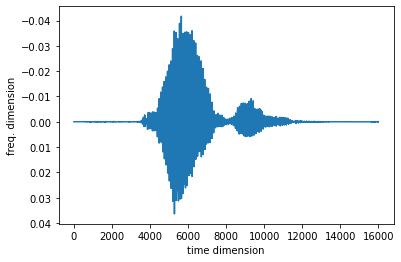

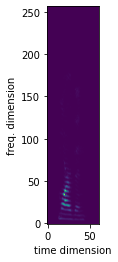

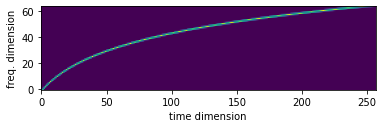

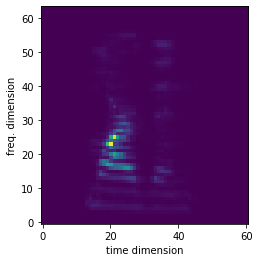

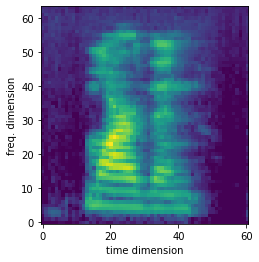

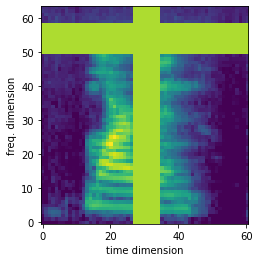

In [ ]:
#@title Plot and export preprocessing pipeling for random dataset sample { vertical-output: true, display-mode: "form" }
# Set hyperparameters
params = {'sample_rate': 16_000, 'min_freq': 0, 'max_freq': 8_000}
hparams = {
    'frame_size': 512,
    'frame_step': 256,
    'fft_size': 512,
    'mel_bins': 64,

    'num_mfccs': 26,

    'max_time_mask': 10,
    'max_freq_mask': 10
}

# Fetch one example
data, label = next(pos_example_iterator)
print(data.shape)


# data = loaded_data[:, 16_000:32_000, :]
# data = tf.reshape(data, (1, -1))
data_squeezed = data.numpy().squeeze()

spectrogram = layers.Spectrogram(params, hparams)(data)
spectrogram_squeezed = spectrogram.numpy().squeeze()

mel_spectrogram_layer = layers.MelSpectrogram(params, hparams)
mel_filterbank = mel_spectrogram_layer.mel_filterbank
mel_filterbank_squeezed = mel_filterbank.numpy().squeeze()

mel_spectrogram = mel_spectrogram_layer(spectrogram)
mel_spectrogram_squeezed = mel_spectrogram.numpy().squeeze()

###
dbscale_mel_spectrogram = layers.DbMelSpectrogram(params, hparams)(mel_spectrogram)
dbscale_mel_spectrogram_squeezed = dbscale_mel_spectrogram.numpy().squeeze()

# dbscale_mfccs = layers.MFCC(params, hparams)(dbscale_mel_spectrogram)
# dbscale_mfccs_squeezed = dbscale_mfccs.numpy().squeeze()

dbscale_time_mask = layers.TimeMask(params, hparams)(dbscale_mel_spectrogram, training=True)
dbscale_time_mask_squeezed = dbscale_time_mask.numpy().squeeze()

dbscale_freq_mask = layers.FrequencyMask(params, hparams)(dbscale_time_mask, training=True)
dbscale_freq_mask_squeezed = dbscale_freq_mask.numpy().squeeze()
###

# ###
# log_mel_spectrogram = layers.LogMelSpectrogram(params, hparams)(mel_spectrogram)
# log_mel_spectrogram_squeezed = log_mel_spectrogram.numpy().squeeze()

# log_mfccs = layers.MFCC(params, hparams)(log_mel_spectrogram)
# log_mfccs_squeezed = log_mfccs.numpy().squeeze()

# log_time_mask = layers.TimeMask(params, hparams)(log_mel_spectrogram)
# log_time_mask_squeezed = log_time_mask.numpy().squeeze()

# log_freq_mask = layers.FrequencyMask(params, hparams)(log_mel_spectrogram)
# log_freq_mask_squeezed = log_freq_mask.numpy().squeeze()
# ###

#print("max log", log_mel_spectrogram_squeezed.min(), log_mel_spectrogram_squeezed.max())
#print("max dbscale", dbscale_mel_spectrogram_squeezed.min(), dbscale_mel_spectrogram_squeezed.max())

arrays = [
    ("Waveform", data_squeezed, False),
    ("Spectrogram", spectrogram_squeezed, False),
    ("Mel-Filterbank", mel_filterbank_squeezed, False),
    ("Mel-Spectrogram", mel_spectrogram_squeezed, False),
    ("(DbScale) Mel-Spectrogram", dbscale_mel_spectrogram_squeezed, False),

    # ("(DbScale) Time mask", dbscale_time_mask_squeezed, False),
    ("(DbScale) Frequency mask", dbscale_freq_mask_squeezed, False),
    # ("(DbScale) MFCCs", dbscale_mfccs_squeezed, False),

    # ("(Log) Mel-Spectrogram", log_mel_spectrogram_squeezed, False),
    # ("(Log) Time mask", log_time_mask_squeezed, False),
    # ("(Log) Frequency mask", log_freq_mask_squeezed, False),
    # ("(Log) MFCCs", log_mfccs_squeezed, False),
]

for name, data, log_transform in arrays:
    _func = plt.plot if data.ndim < 2 else plt.imshow
    plt.figure()
    # plt.title(f"{name}    {data.shape}    {'[LOG-SCALED AXIS]' if log_transform else ''}", color='black')
    if log_transform:    
        _func(tf.math.log(data.T))
    else:
        _func(data.T)
    plt.gca().invert_yaxis()
    plt.xlabel("time dimension")
    plt.ylabel("freq. dimension")
    plt.savefig(f"/tmp/{name.lower().replace(' ', '_')}.png", dpi=288)

display.Audio(data_squeezed, rate=params['sample_rate'])

0.953125
0.23828125
0.953125
0.953125
0.953125
0.953125


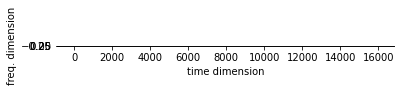

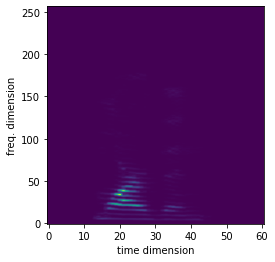

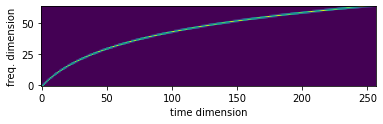

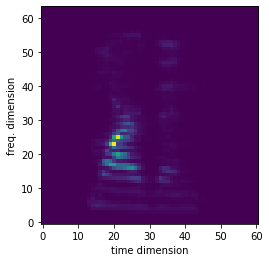

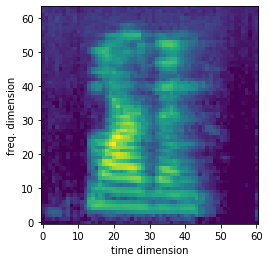

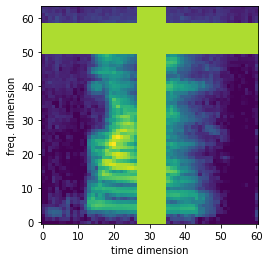

In [ ]:
#@title Replot spectrogram with similar aspect ratio

arrays = [
    ("Waveform", data_squeezed, False),
    ("Spectrogram", spectrogram_squeezed, False),
    ("Mel-Filterbank", mel_filterbank_squeezed, False),
    ("Mel-Spectrogram", mel_spectrogram_squeezed, False),
    ("(DbScale) Mel-Spectrogram", dbscale_mel_spectrogram_squeezed, False),

    # ("(DbScale) Time mask", dbscale_time_mask_squeezed, False),
    ("(DbScale) Frequency mask", dbscale_freq_mask_squeezed, False),
    # ("(DbScale) MFCCs", dbscale_mfccs_squeezed, False),

    # ("(Log) Mel-Spectrogram", log_mel_spectrogram_squeezed, False),
    # ("(Log) Time mask", log_time_mask_squeezed, False),
    # ("(Log) Frequency mask", log_freq_mask_squeezed, False),
    # ("(Log) MFCCs", log_mfccs_squeezed, False),
]

for name, data, log_transform in arrays:
    _func = plt.plot if data.ndim < 2 else plt.imshow
    plt.figure()
    # plt.title(f"{name}    {data.shape}    {'[LOG-SCALED AXIS]' if log_transform else ''}", color='black')
    if log_transform:    
        _func(tf.math.log(data.T))
    else:
        _func(data.T)
    
    plt.gca().set_aspect(61/64)
    if name == "Spectrogram":
        plt.gca().set_aspect(61/256)

    plt.gca().invert_yaxis()
    print(plt.gca().get_aspect())
    plt.xlabel("time dimension")
    plt.ylabel("freq. dimension")
    plt.savefig(f"/tmp/{name.lower().replace(' ', '_')}.png", dpi=288, transparent=True)

display.Audio(data_squeezed, rate=params['sample_rate'])

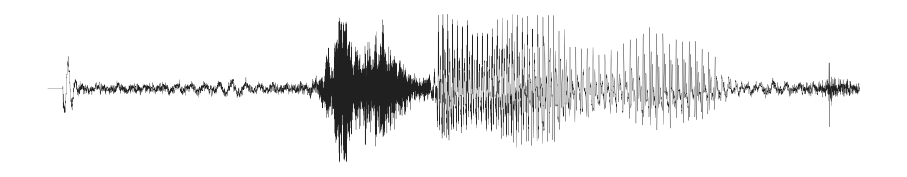

In [ ]:
#@title Plot and export high resolution positive audio sample { vertical-output: true, display-mode: "form" }
data, label = next(neg_example_iterator)
data_squeezed = data.numpy().squeeze()
time=np.linspace(0, 1, num=len(data_squeezed))
plt.figure(figsize=(16,3))
plt.plot(time,data_squeezed, linewidth=.250, color="#202020")
plt.axis("off")
plt.savefig('/tmp/highres-audio-negative.png', dpi=560, transparent=True)
display.Audio(data_squeezed, rate=16_000)

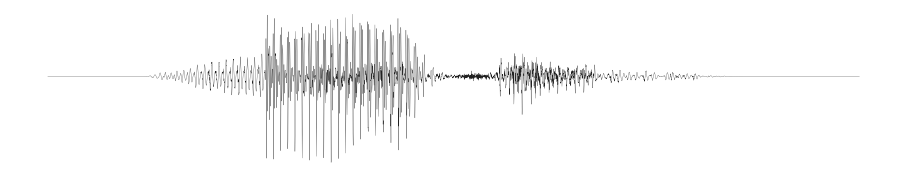

In [ ]:
#@title Plot and export high resolution negative audio sample { vertical-output: true, display-mode: "form" }
data, label = next(pos_example_iterator)
# # data_squeezed = data.numpy().squeeze()
# time=np.linspace(0, 1, num=len(data_squeezed))
plt.figure(figsize=(16,3))
plt.axis("off")
plt.plot(time,data_squeezed, linewidth=.250, color="#202020")
plt.savefig('/tmp/highres-audio.png', dpi=560, transparent=True)